# SRM | Signal Request Message Counts
Notebook to calculate SRM counts

Version | Date | Author | Notes |
:------:|:----:|:------:|:--------
1.0     | 21 July 2022 | Ken Dizon - CDOT OIM  | Initial version 
1.1     | 10 Nov 2022  | Ken Dizon - CDOT OIM  | Query Input Parameters
2.0     | 07 Feb 2023  | Ken Dizon - CDOT OIM  | Intersections within a specific day

**[OBU] sends ➡ SRM**
- Locate valid Signal Request Messages in a RSU.
- SRM (Signal Request Message) as not all intersections will receive a request.
- Broadcast by a vehicle (OnBoard Unit) to infrastructure (Roadside Unit)

_______________
**Content**
- Libraries & Packages
- SQL Setup & Parameters
- Query
1. SRM: Signal Request Message
    * 1.1 Counts
    * 1.2 Visualization
2. SRM: daily exchange

In [1]:
# Importing Libraries
from google.cloud import bigquery

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from datetime import (datetime, timedelta)

SQL Big Query Setup & Parameters

In [2]:
# BigQuery Connection
client = bigquery.Client(location="US", project="cdot-adap-wb-stage")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: cdot-adap-wb-stage


In [3]:
# From a start date and input number of days after
start_date = input('Enter a start date in (YYYY-MM-DD): ')
start_date = datetime.strptime(start_date, "%Y-%m-%d").date()

num_days = int(input("Enter number of days: "))
end_date = start_date + timedelta(days=num_days)
print('End date:', end_date)

Enter a start date in (YYYY-MM-DD):  2023-01-01
Enter number of days:  60


End date: 2023-03-02


Query

In [4]:
%%time

query = """
SELECT
    srm.metadata.originIp AS rsuIP,
    DATE(
        EXTRACT(YEAR FROM TIMESTAMP(srm.metadata.odeReceivedAt) AT TIME ZONE "America/Denver"),
        EXTRACT(MONTH FROM TIMESTAMP(srm.metadata.odeReceivedAt) AT TIME ZONE "America/Denver"),
        EXTRACT(DAY FROM TIMESTAMP(srm.metadata.odeReceivedAt) AT TIME ZONE "America/Denver")
    ) AS localDate,
    count(1) AS SRM_count
FROM cdot-adap-prod.raw_from_rtdh_standard.cv_srm_standard
WHERE srm.metadata.originIp LIKE @Region1
    AND DATETIME(TIMESTAMP(srm.metadata.odeReceivedAt), \"America/Denver\") BETWEEN @start_date AND @end_date
GROUP BY localDate, rsuIP
ORDER BY localDate, rsuIP
"""

query_params = [ 
    bigquery.ScalarQueryParameter("Region1", "STRING", '%10.11.81%'), # displays SRM counts by using all RSUs from 10.11.81.## located on Wadsworth Blvd
    bigquery.ScalarQueryParameter("start_date", "DATE", start_date), 
    bigquery.ScalarQueryParameter("end_date", "DATE", end_date), 
]

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params

CPU times: user 93 µs, sys: 17 µs, total: 110 µs
Wall time: 115 µs


## 1. Signal Request Message
**1.1 SRM Counts**

In [5]:
# execute the query
SRM = client.query(query, job_config=job_config).to_dataframe()
SRM.head()

,rsuIP,localDate,SRM_count
0,10.11.81.18,2023-01-01,95
1,10.11.81.19,2023-01-01,74
2,10.11.81.14,2023-01-02,111
3,10.11.81.18,2023-01-02,480
4,10.11.81.19,2023-01-02,437


In [6]:
SRM.shape

(45, 3)

In [7]:
# pivot
SRMCountTable = pd.pivot(SRM,index='localDate', columns='rsuIP', values='SRM_count').fillna(0)

In [8]:
SRMCountTable.head()

rsuIP,10.11.81.13,10.11.81.14,10.11.81.18,10.11.81.19,10.11.81.20,10.11.81.21,10.11.81.22,10.11.81.23,10.11.81.24,10.11.81.25,10.11.81.26,10.11.81.27,10.11.81.28
localDate,,,,,,,,,,,,,
2023-01-01,0,0,95,74,0,0,0,0,0,0,0,0,0
2023-01-02,0,111,480,437,107,149,192,211,216,204,113,126,128
2023-01-03,0,717,224,330,208,987,1176,1181,1046,963,477,410,384
2023-01-05,0,0,10,7,0,0,0,0,0,0,0,0,0
2023-01-13,184,209,86,120,57,189,258,233,206,183,122,120,126


**1.2 SRM Visualization**

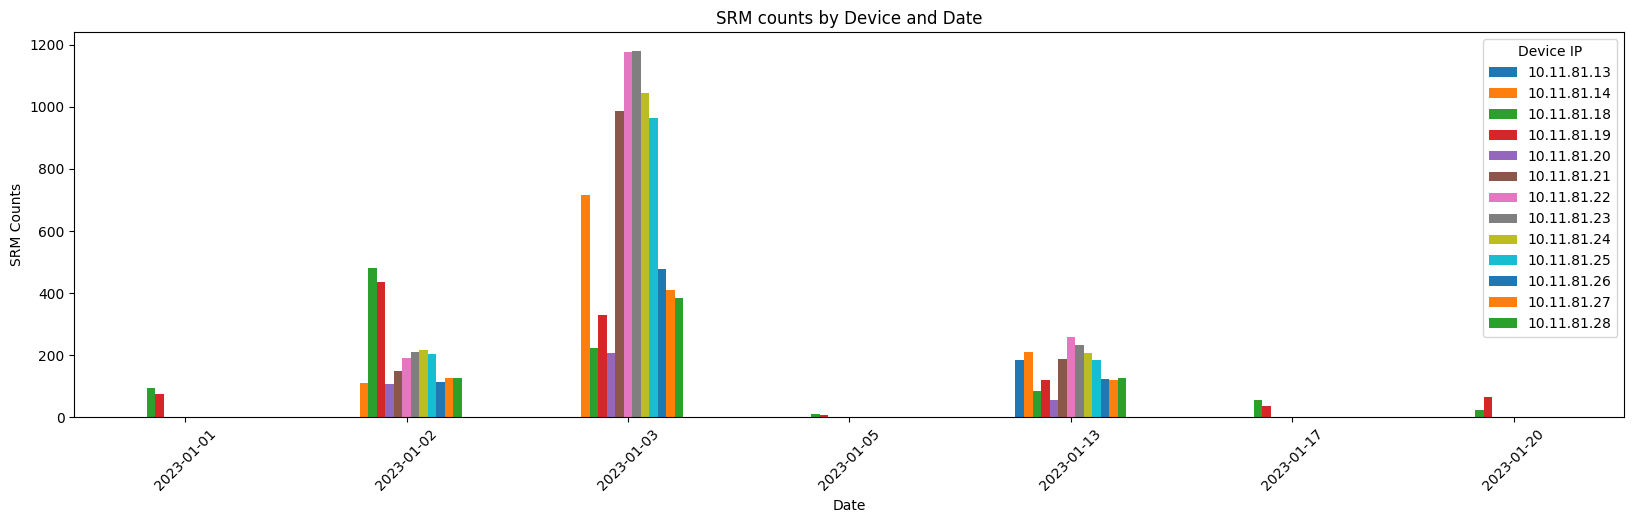

In [9]:
# Plot a bar chart using the PivotTable
ax = SRMCountTable.plot(kind="bar")

fig = ax.get_figure()
fig.set_size_inches(20, 5)

# Add some labels and a legend
ax.set_title('SRM counts by Device and Date')
ax.legend(title='Device IP')
ax.set_xlabel('Date')
ax.set_ylabel('SRM Counts')
plt.xticks(rotation=45)
plt.show()

### 2. Daily Exchange
- Selecting SRMs within a single day

In [10]:
start_day = '2023-01-03 00:00:00.000000'
end_day = '2023-01-03 23:59:00.000000'

In [11]:
%%time

query = """
SELECT
DATETIME(TIMESTAMP(srm.metadata.odeReceivedAt), \"America/Denver\") AS ode_timeStamp,
srm.metadata.originIp as rsuIP,
srm.payload.data.sequenceNumber AS MsgCount,
SignalRequestsList.request.id.id AS IntersectionID, 
SignalRequestsList.request.requestID AS RequestID
FROM
cdot-adap-prod.raw_from_rtdh_standard.cv_srm_standard,
UNNEST(srm.payload.data.requests.signalRequestPackage) AS SignalRequestsList
WHERE
DATETIME(TIMESTAMP(srm.metadata.odeReceivedAt), \"America/Denver\") BETWEEN @start_day AND @end_day
ORDER BY ode_timeStamp
"""

query_params = [ 
    bigquery.ScalarQueryParameter("Region1", "STRING", '%10.11.81%'), # displays SRM counts by using all RSUs from 10.11.81.## located on Wadsworth Blvd
    bigquery.ScalarQueryParameter("start_day", "STRING", start_day), 
    bigquery.ScalarQueryParameter("end_day", "STRING", end_day), 
]

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params

CPU times: user 39 µs, sys: 8 µs, total: 47 µs
Wall time: 51 µs


In [12]:
# execute the query
srm_df = client.query(query, job_config=job_config).to_dataframe()
srm_df.head()

,ode_timeStamp,rsuIP,MsgCount,IntersectionID,RequestID
0,2023-01-03 00:00:58.325663,10.11.81.18,1,12114,111
1,2023-01-03 00:00:58.337020,10.11.81.19,1,12114,111
2,2023-01-03 00:00:59.327788,10.11.81.18,2,12114,111
3,2023-01-03 00:00:59.337788,10.11.81.19,2,12114,111
4,2023-01-03 00:01:00.336525,10.11.81.18,3,12114,111


In [13]:
srm_df.shape

(8103, 5)

**2.2 Single day SRMs received by RSU**
- Create a time series chart to show SRMs for each intersectionID

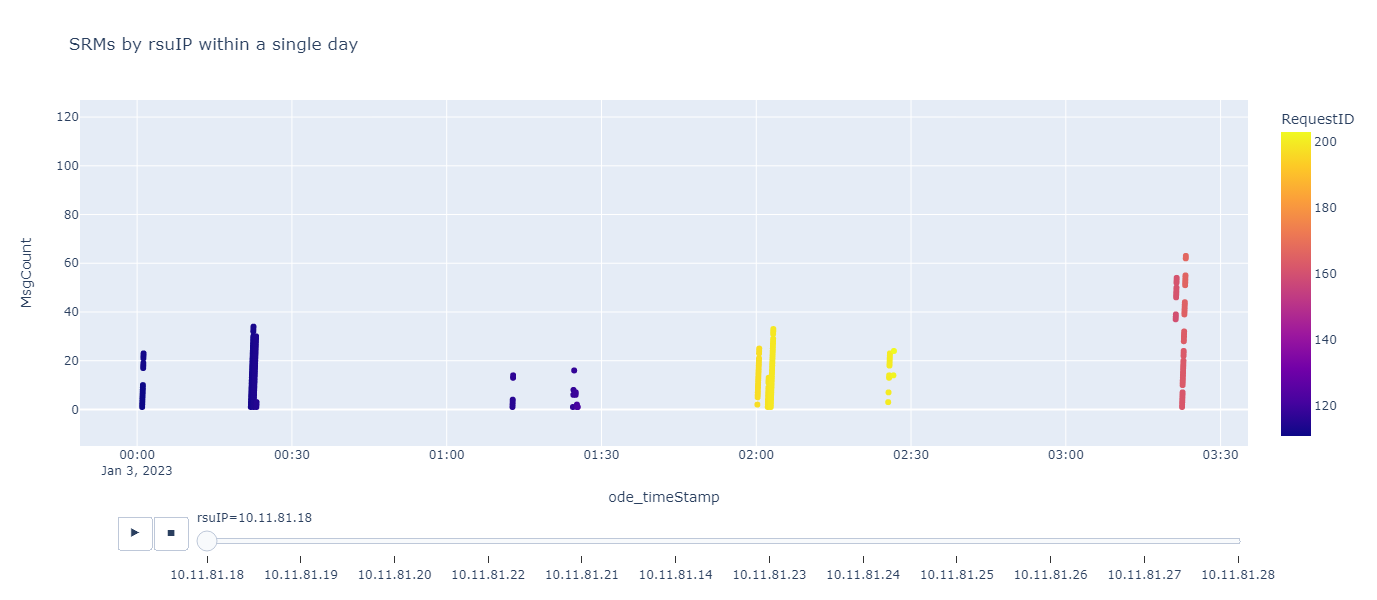

In [25]:
# create a scatter plot for each IntersectionID
fig = px.scatter(srm_df, x='ode_timeStamp', y='MsgCount', color='RequestID',
                 title='SRMs by rsuIP within a single day',
                 width=1200, height=600,
                 animation_frame='rsuIP', range_y=[-15, srm_df['MsgCount'].max()])
fig.show()